# Dennis Briner 06.11.2021

In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

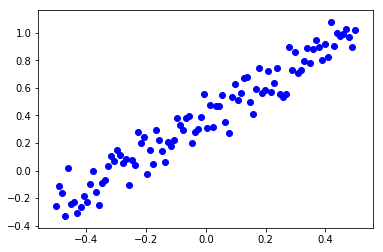

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[-0.41930383]])
b: variable b([ 0.])
Operations on chainer.Variable: variable([[ 122.58069611]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[-0.41930383]] [[ 122.58069611]]


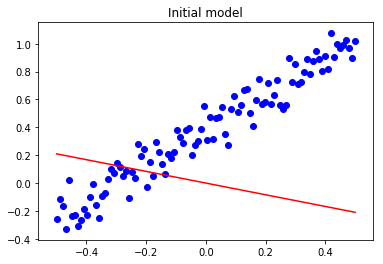

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [5]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.397856205701828)
dloss/dW [[-0.28664932]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.6813616752624512)
Itr 25 loss: variable(0.23182587325572968)
Itr 50 loss: variable(0.10355668514966965)
Itr 75 loss: variable(0.049141909927129745)


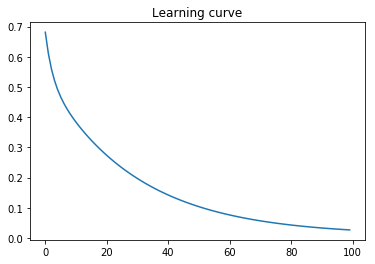

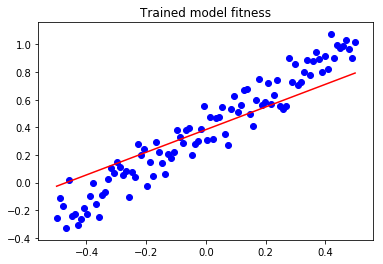

In [6]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []

alpha = 0.1 # learning rate

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))

    # backprob and update weights and bias according to the learning rate
    loss.backward()    
    model.W.data -= alpha * model.W.grad
    model.b.data -= alpha * model.b.grad

    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")

In [7]:
# Compare my approximated results with the initial values chosen to create the test data set
print("RESULTS: ")

print("True A was", true_a, "I got", model.W.data[0][0])
print("True B was", true_b, "I got", model.b.data[0])

RESULTS: 
True A was 1.3 I got 0.819251
True B was 0.4 I got 0.383647


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


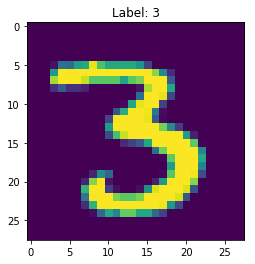

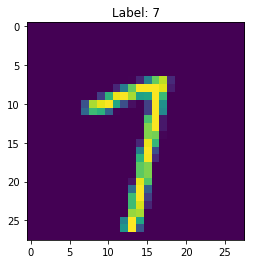

In [9]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [10]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            #if itr % 300 == 0:
                # print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [11]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # activate all layers in our multi layer perceptron
        output_l1 = F.relu(self.l1(x))
        output_l2 = F.relu(self.l2(output_l1))
        output_l3 = self.l3(output_l2)
        
        return output_l3
run(MLP(200, 10))

Next you should try to implement logging test loss and see if the model is overfitting.

Iteration 0 loss: 2.28861689568; accuracy: 0.1875
Iteration 300 loss: 0.566051079035; accuracy: 0.86875
Iteration 600 loss: 0.396139651537; accuracy: 0.895
Iteration 900 loss: 0.345742154717; accuracy: 0.91875
Iteration 1200 loss: 0.258284321427; accuracy: 0.9175
Iteration 1500 loss: 0.254258603454; accuracy: 0.9375
Iteration 1800 loss: 0.275507938266; accuracy: 0.91875
Iteration 0 loss: 0.201493073106; accuracy: 0.95
Iteration 300 loss: 0.217640229762; accuracy: 0.93625
Iteration 600 loss: 0.247848943472; accuracy: 0.92875
Iteration 900 loss: 0.232055054009; accuracy: 0.925
Iteration 1200 loss: 0.214628314376; accuracy: 0.935
Iteration 1500 loss: 0.220202744007; accuracy: 0.93875
Iteration 1800 loss: 0.162732592821; accuracy: 0.94625
Iteration 0 loss: 0.194626482725; accuracy: 0.94
Iteration 300 loss: 0.176858404279; accuracy: 0.9475
Iteration 600 loss: 0.155505464673; accuracy: 0.95625
Iteration 900 loss: 0.132386411726; accuracy: 0.96
Iteration 1200 loss: 0.167983131111; accuracy: 0

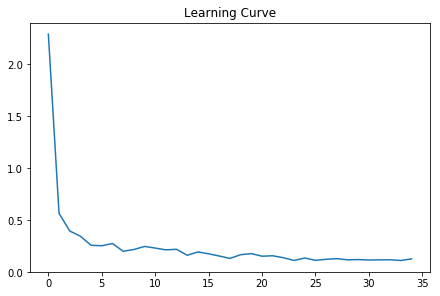

In [12]:
def better_run(model, shuffle, batchsize=32, num_epochs=5):

    # modify learning rate here
    optimizer = chainer.optimizers.Adam(alpha=0.0001) # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=shuffle)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # keep the mean loss to visualize the learning process
                losses.append(np.mean(stats["loss"]))
                print("Iteration", itr, "; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))
                
    return losses


losses = better_run(MLP(200, 10), shuffle=True)

# Plot the learning process
fig, ax = plt.subplots(constrained_layout=True)
ax.set_title("Learning Curve")
ax.plot(losses)

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc

In [85]:
# sort train data so that we can evaluate the consecutive sampling of the same number (start with just 0s then 1s, 2s, etc.)
train = sorted(train, key=lambda x: x[1])

Iteration 0 accuracy: 0.0; loss: 2.37376642227
Iteration 300 accuracy: 1.0; loss: 0.0193695241213
Iteration 600 accuracy: 0.23875; loss: 4.48973956943
Iteration 900 accuracy: 1.0; loss: 0.0163374987245
Iteration 1200 accuracy: 1.0; loss: 0.172397643924
Iteration 1500 accuracy: 1.0; loss: 0.00670961618423
Iteration 1800 accuracy: 1.0; loss: 0.0561146466434
Iteration 0 accuracy: 0.96; loss: 0.287567922771
Iteration 300 accuracy: 0.9975; loss: 0.0174866847694
Iteration 600 accuracy: 0.435; loss: 2.06886228114
Iteration 900 accuracy: 1.0; loss: 0.00873975798488
Iteration 1200 accuracy: 1.0; loss: 0.0246420493722
Iteration 1500 accuracy: 1.0; loss: 0.00660650826991
Iteration 1800 accuracy: 1.0; loss: 0.0185620801896
Iteration 0 accuracy: 0.9625; loss: 0.0994022443146
Iteration 300 accuracy: 0.9925; loss: 0.0245737098157
Iteration 600 accuracy: 0.6425; loss: 1.14474955767
Iteration 900 accuracy: 1.0; loss: 0.00516285896301
Iteration 1200 accuracy: 0.9975; loss: 0.0148991868272
Iteration 1500

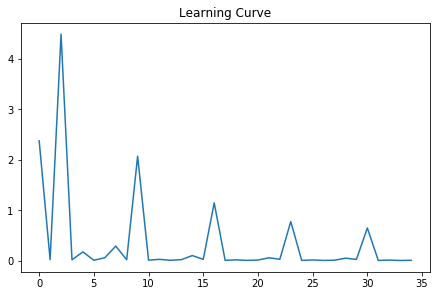

In [86]:
# Try our MLP without shuffling the data set (I modified the better_run method and added an option to disable shuffling)
losses = better_run(MLP(200, 10), shuffle=False)

# Plot the learning curve
# Here is is really overfitting quite hard. After every new number the loss jumps again.
fig, ax = plt.subplots(constrained_layout=True)
ax.set_title("Learning Curve")
ax.plot(losses)